**Deberá entrenar un modelo de clasificación para generar las respuestas que hará el 
servicio, el código deberá hacerlo en un Jupyter notebook, el output de esta ejecución 
será un archivo con el modelo entrenado y un txt con las métricas generadas por este, 
también indicaciones de que modelo usó, cantidad de datos de entrenamiento, testeo, 
etc. Es libre de hacer reducción de dimensionalidad, escalado, aumento de data, balanceo 
de data o cualquier técnica que mejore su pronóstico. (Tenga en cuenta que si redujo la 
cantidad de variables predictoras para el momento de hacer el pronóstico debe hacerlo 
también a esos datos)**

### 1. Instalación e importación de librerías

In [ ]:
!pip install xgboost dill

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer,  ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import dill


### 2. Exploración de datos

In [ ]:
# Lectura del documento

df=pd.read_csv("dataset_alpha_betha.csv")
df.head()

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\123\AppData\Local\Temp\ipykernel_19100\3277995551.py:3: SyntaxWarning: invalid escape sequence '\d'
  df=pd.read_csv(".\data\dataset_alpha_betha.csv")


,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha


In [5]:
# Chequeo valores nulos

print(f"Valores nulos en la data:\n\n{df.isnull().sum()}")

Valores nulos en la data:

autoID              0
SeniorCity          0
Partner             0
Dependents          0
Service1            0
Service2            0
Security            0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges             0
Demand              0
Class               0
dtype: int64


In [6]:
# Contenido de la información
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

In [7]:
# Revisón contenido de cada columna

for i in df.columns:
  print("\n",i,"\n")
  print(df[i].value_counts())


 autoID 

autoID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
4501-VCPFK    1
6075-SLNIL    1
             ..
1452-KIOVK    1
6713-OKOMC    1
7892-POOKP    1
6388-TABGU    1
9763-GRSKD    1
Name: count, Length: 7043, dtype: int64

 SeniorCity 

SeniorCity
0    5901
1    1142
Name: count, dtype: int64

 Partner 

Partner
No     3641
Yes    3402
Name: count, dtype: int64

 Dependents 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64

 Service1 

Service1
Yes    6361
No      682
Name: count, dtype: int64

 Service2 

Service2
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

 Security 

Security
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

 OnlineBackup 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

 DeviceProtection 

DeviceProtection
No                     3095
Yes            

### 3. Criterios de entrenamiento y definición de modelos

1. El enunciado indica llenado de datos por medio de una lista desplegable, lo que garantiza la integridad de los datos; "autoID" corresponde al ID del registro, por lo que no se considera importante para el entrenamiento del modelo.

2. La columna Demand también hace parte de la predicción objetivo, por lo que no se tendrá en cuenta

3. También se identifica un desbalance de las clases aproximadamente en una relación de 3:1, por lo que debe tenerse en cuenta para la correcta selección de datos y configuración del entrenamiento con criterios de desbalance de clases

4. Después de analizar repetidas veces varios comportamientos de modelos, se analiza reducción de dimensionalidad, en este caso, como la mayoría de las variables son categoricas, se toman las principales variables que entrga un random forest con hiperparámetros óptimos encontrados en el desarrollo del ejercicio

In [10]:
# Categorización de la clase a evaluar

df["Class"]=df["Class"].replace({"Alpha":0, "Betha":1})
y=df["Class"]

C:\Users\123\AppData\Local\Temp\ipykernel_19100\1097345979.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Class"]=df["Class"].replace({"Alpha":0, "Betha":1})


In [11]:
columns=[ 'SeniorCity', 'Partner', 'Dependents', 'Service1', 'Service2',
       'Security', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges']

df_model=df[columns].copy()

# Partición de datos para entrenamiento y testeo con estratificación desbalanceada dada la naturaleza de las clases

X_train, X_test, y_train, y_test = train_test_split(df_model, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
# Clase generada para aplicar label encoder en el pipeline de entrenamiento

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.label_encoders = {col: LabelEncoder().fit(X[col]) for col in X.columns}
        return self

    def transform(self, X):
        return X.apply(lambda col: self.label_encoders[col.name].transform(col))



In [ ]:
# Análisis de reducción de dimensionalidad


cat=[ 'SeniorCity', 'Partner', 'Dependents', 'Service1', 'Service2',
       'Security', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod']
num = ['Charges']

# Transformador para las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', LabelEncoderTransformer(), cat),  # Aplicar LabelEncoder
        ('num', StandardScaler(), num)  # Escalar las columnas numéricas
    ]
)

model=RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=400, max_depth=10,min_samples_split=10 )

# Creación de pipeline que contiene la transformación de los datos por Label Encoder y los modelos a evaluar
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('RF', model)])
pipeline.fit(X_train, y_train)

importances=pipeline.named_steps['RF'].feature_importances_

# Asegúrate de tener las características correctas
features = cat + num  # Combina las columnas categóricas y numéricas

# Crear un DataFrame para ver las importancias junto con las características
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Ordenar las características por su importancia
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)



             feature  importance
9           Contract    0.260313
12           Charges    0.194959
5           Security    0.130319
8        TechSupport    0.104776
11     PaymentMethod    0.074519
6       OnlineBackup    0.060937
7   DeviceProtection    0.040027
10  PaperlessBilling    0.033758
4           Service2    0.024013
2         Dependents    0.023374
1            Partner    0.022955
0         SeniorCity    0.020065
3           Service1    0.009984


In [19]:
# Selección de características importantes
features=[ 'Security', 'OnlineBackup','TechSupport', 'Contract', 'PaymentMethod', 'Charges']
X_train=X_train[features]
X_test=X_test[features]

In [20]:


# Definir las columnas categóricas y numéricas

categorical_columns=[ 'Security', 'OnlineBackup','TechSupport', 'Contract', 'PaymentMethod']
numeric_columns = ['Charges']

# Crear un transformador para las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', LabelEncoderTransformer(), categorical_columns),  # Aplicar LabelEncoder
        ('num', StandardScaler(), numeric_columns)  # Escalar las columnas numéricas
    ]
)

# Definición de modelos a evaluar con el criterio de desbalance de clases
models = {
    'random_forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'SVC': svm.SVC(probability=True, random_state=42, class_weight='balanced'),
     'xgboost': XGBClassifier(random_state=42)
}


# Creación de pipeline que contiene la transformación de los datos por Label Encoder y los modelos a evaluar
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
             for name, model in models.items()}


# Calcular scale_pos_weight, factor que usa el modelo XBOOST para el caso de clases desbalanceadas
neg_class = (y_train == 0).sum()
pos_class = (y_train == 1).sum()
scale_pos_weight = neg_class / pos_class

# Selección de variables para ajuste de hiperparámetros 
param_grids = {
    'random_forest': {
        'classifier__n_estimators': [200,300,400],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'SVC': {
        'classifier__kernel': ["linear", "poly", "rbf"],
        'classifier__C': [1, 10, 50, 100],
        
    },
    'xgboost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.7, 0.8, 1.0],
        'classifier__colsample_bytree': [0.7, 0.8, 1.0],
        'classifier__scale_pos_weight': [scale_pos_weight],  # Ajuste para desbalance
        'classifier__gamma': [0, 0.1, 0.2],
        'classifier__reg_alpha': [0, 0.01, 0.1],
        'classifier__reg_lambda': [1, 10, 100]
    }
}

# Definción de la partición para la validación en entrenamiento con criterio de desbalance de clases
st=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Dado el desbalance, se usará f1 como el escorer en el entrenamiento
scorer = make_scorer(f1_score, average='macro')


### 4. Ciclo de Entrenamiento

In [21]:

# Evaluar los modelos con GridSearchCV
best_models = {}
for name, pipeline in pipelines.items():
    print(f"Evaluating {name}...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[name], cv=st, scoring=scorer, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best cross-validated f1 for {name}: {grid_search.best_score_:.4f}")




Evaluating random_forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for random_forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 400}
Best cross-validated f1 for random_forest: 0.7057
Evaluating SVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for SVC: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best cross-validated f1 for SVC: 0.6990
Evaluating xgboost...
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Best params for xgboost: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1, 'classifier__scale_pos_weight': np.float64(2.768561872909699), 'classifier__subsample': 0.7}
Best cross-validated f1 for xgboost: 0.7102


### 5. Test con los mejores modelos encontrados

In [22]:
# Evaluar los mejores modelos en el conjunto de prueba
print("\nResultados con los datos del test:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    BACC = balanced_accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    print(f"{name} BACC: {BACC:.4f}, F1: {f1:.4f}")


Resultados con los datos del test:
random_forest BACC: 0.7318, F1: 0.5944
SVC BACC: 0.7324, F1: 0.5890
xgboost BACC: 0.7322, F1: 0.5926


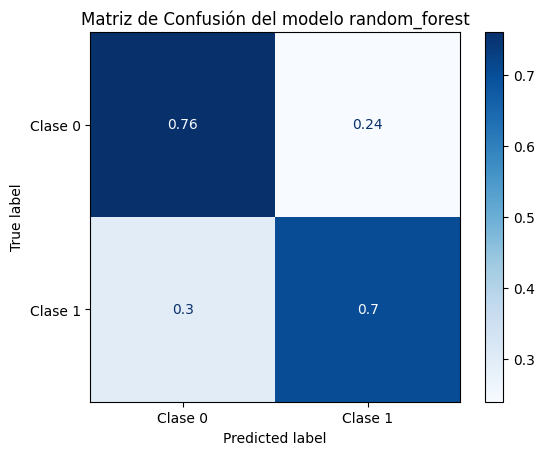

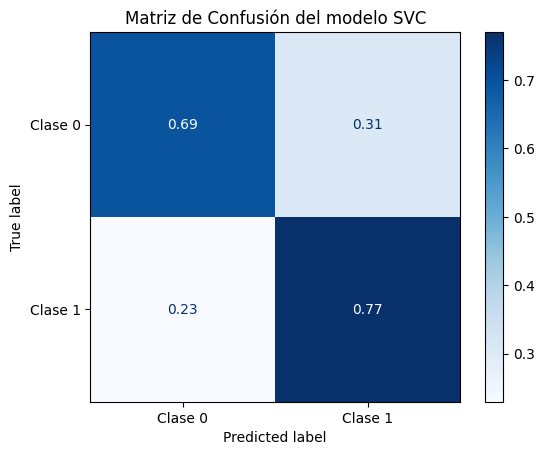

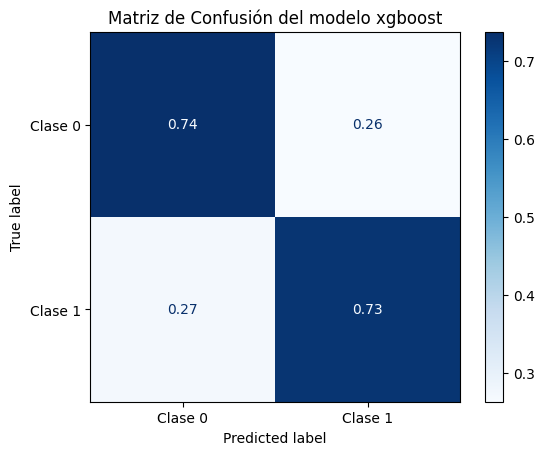

In [23]:
# matriz de confusión para cada modelo

for name, model in best_models.items():

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión del modelo {name}")
    plt.show()

### 6. Elección del modelo

Se toma el modelo de XBOOST con los hiperparámetros ajustados ya que es el modelo que entrega mejores resultados para la clasificación de ambas clases

In [24]:
model=best_models['xgboost']
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  LabelEncoderTransformer(),
                                                  ['Security', 'OnlineBackup',
                                                   'TechSupport', 'Contract',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['Charges'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, devic...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [25]:
#Guardado del modelo
with open('model_xg.pkl', 'wb') as f:
    dill.dump(model, f)



In [26]:
# Verificación de serialización para despliegue
with open('model_xg.pkl', 'rb') as f:
    model = dill.load(f)

print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  LabelEncoderTransformer(),
                                                  ['Security', 'OnlineBackup',
                                                   'TechSupport', 'Contract',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['Charges'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, devic...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
   